# SMAI Assignment - 2

## Question 2: Gaussian Mixture Models

Resources:
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2


### Part 1: Gaussian Mixture Models

We'll attempt to solve the task of background subtraction using Gaussian Mixture Models. Before that, you will need to implement the Gaussian Mixture Model algorithm from scratch.

Some details:
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.
- The following code cell has a rough template to get you started with the implementation. You are free to change the structure of the code, this is just a suggestion to help you get started.


TLDR: You may implement the univariate version of GMMs, but it might not be as accurate as the multivariate version and it is recommended to try and implement the multivariate version.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM(object):

    def __init__(self, n_components=1, tol=1e-3, max_iter=100):
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.weights = None
        self.means = None
        self.covars = None

    def initialize_params(self, X):
        n_samples, n_features = X.shape

        # Randomly initialize weights
        self.weights = np.ones(self.n_components) / self.n_components

        # Randomly initialize means
        random_indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[random_indices]

        # Initialize covariances using the sample covariance of the data
        self.covars = np.array([np.cov(X.T) for _ in range(self.n_components)])

    def E_step(self, X):
        responsibilities = np.zeros((X.shape[0], self.n_components))

        for k in range(self.n_components):
            multivariate_dist = multivariate_normal(self.means[k], self.covars[k])
            responsibilities[:, k] = self.weights[k] * multivariate_dist.pdf(X)

        # Normalize responsibilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        return responsibilities

    def M_step(self, X, responsibilities):
        total_responsibilities = np.sum(responsibilities, axis=0)

        # Update weights
        self.weights = total_responsibilities / X.shape[0]

        # Update means
        self.means = np.dot(responsibilities.T, X) / total_responsibilities[:, np.newaxis]

        # Update covariances
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covars[k] = np.dot(responsibilities[:, k] * diff.T, diff) / total_responsibilities[k]

    def fit(self, X, y=None):
        self.initialize_params(X)

        for iteration in range(self.max_iter):
            # E-step
            responsibilities = self.E_step(X)

            # M-step
            self.M_step(X, responsibilities)

            # Check for convergence
            if np.abs(self.weights.sum() - 1.0) < self.tol:
                break

    def predict(self, X):
        responsibilities = self.E_step(X)
        return np.argmax(responsibilities, axis=1)


### Part 2: Background Subtraction

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly.

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Most of the time, the Gaussian with the higher weight corresponds to the background.
    - We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to the first baseline above.
    - To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    - This method is much simpler to implement but, this could give worse results.

#### Extracting Frames from videos

In [ ]:
source_folder = 'videos'
video = 'traffic.gif'

source_path = f'./drive/MyDrive/{source_folder}/{video}'

In [ ]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"

In [ ]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [ ]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

#### Loading Frames

In [ ]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = np.asarray(img, dtype=np.float64)
    img /= 255.0

    frames.append(img)

frames = np.asarray(frames, dtype=np.float64)

#### Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


Note: You may use helper libraries like `imageio` for working with GIFs.

```python
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps)
    return
```

#### Frame Averaging

Extract Background Image from the training data and display it.

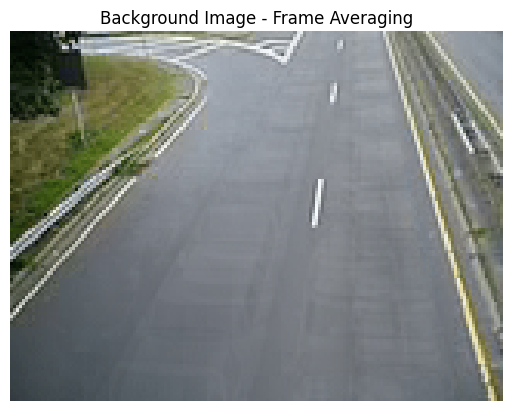

In [ ]:
# your code here
# Frame Averaging
background_image = np.mean(train_frames, axis=0)

# Display the background image
plt.imshow(background_image)
plt.title("Background Image - Frame Averaging")
plt.axis("off")
plt.show()


#### GMMs per pixel

Create Set of GMMs for every pixel and fit them considering every training frame

In [ ]:
# your code here
from sklearn.mixture import GaussianMixture

class GMMPerPixel(object):

    def __init__(self, n_components=2, tol=1e-3, max_iter=100):
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.gmm_models = []

    def fit(self, X):
        n_samples, n_pixels, n_channels = X.shape

        for i in range(n_pixels):
            gmm = GaussianMixture(n_components=self.n_components, tol=self.tol, max_iter=self.max_iter)
            gmm.fit(X[:, i, :].reshape(-1, n_channels))
            self.gmm_models.append(gmm)

    def predict_background(self, X):
        print(X.shape)
        n_samples, n_pixels, n_channels = X.shape
        background = np.zeros((n_samples, n_pixels, n_channels))

        for i in range(n_pixels):
            background[:, i, :] = self.gmm_models[i].means_[np.argmax(self.gmm_models[i].weights_)]

        return background

# Reshape train frames to (n_samples, n_pixels, n_channels)
n_samples, height, width, channels = train_frames.shape
train_frames_reshaped = train_frames.reshape((n_samples, height * width, channels))

# Initialize and fit GMMs per pixel
gmm_per_pixel = GMMPerPixel(n_components=2, tol=1e-3, max_iter=100)
gmm_per_pixel.fit(train_frames_reshaped)



/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


#### Extract Background Image from the trained model

(48, 19200, 3)


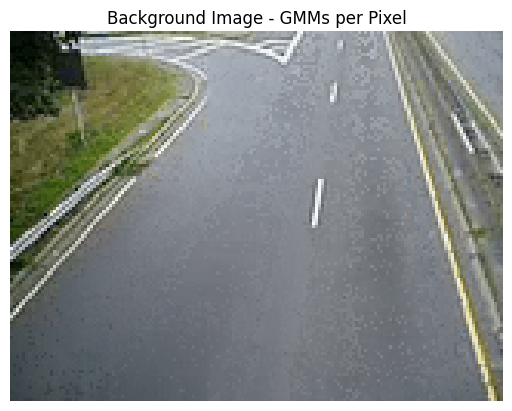

In [ ]:
# your code here
# Extract Background Image from the trained model
background_image_gmm_per_pixel = gmm_per_pixel.predict_background(train_frames_reshaped)

# Reshape back to original dimensions
background_image_gmm_per_pixel = background_image_gmm_per_pixel.reshape((n_samples, height, width, channels))

# Display the background image from GMMs per pixel
plt.imshow(background_image_gmm_per_pixel[0])  # Displaying the background from the first training frame
plt.title("Background Image - GMMs per Pixel")
plt.axis("off")
plt.show()


### Outputs

You can use the helper functions given below to display and save frames as videos, feel free to change them accordingly.

In [ ]:
from google.colab.patches import cv2_imshow
!unzip results.zip

Archive:  results.zip
 extracting: results/dc.txt          


In [ ]:
from google.colab.patches import cv2_imshow

def display_frames(frames, fps=10.0):
    """
    Display the frames as a video.
    """
    eps = 0.0001

    wait_time = int(1000 // fps)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2_imshow(frame)
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break

    cv2.destroyAllWindows()


def save_frames(frames, fps=10.0, output_path='./results', file_name='temp'):
    """
    Save the frames as a video.
    """
    eps = 0.0001

    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")

    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2_imshow(frame)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break

        vid_wrt.write(frame)

    vid_wrt.release()
    cv2.destroyAllWindows()


#### Frame Averaging

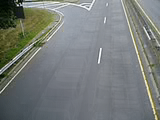

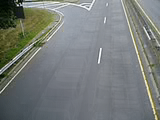

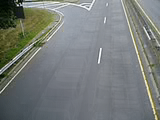

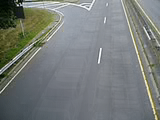

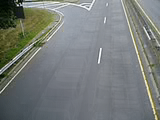

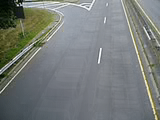

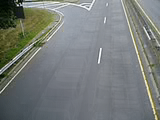

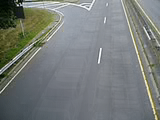

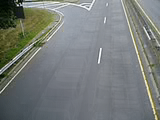

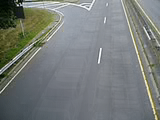

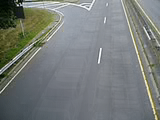

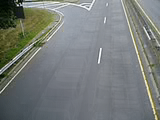

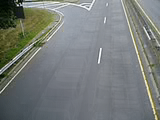

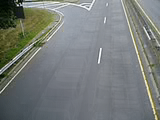

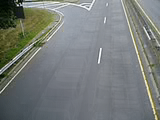

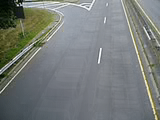

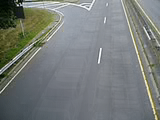

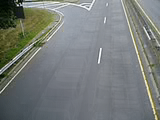

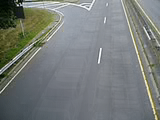

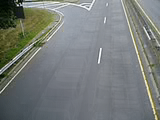

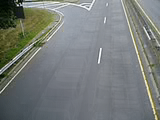

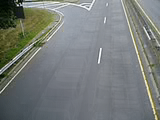

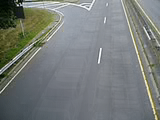

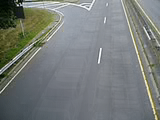

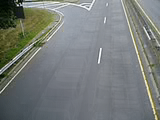

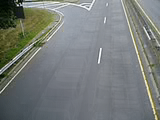

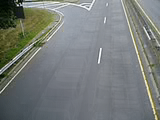

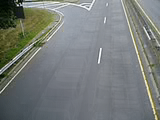

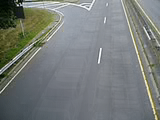

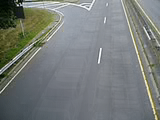

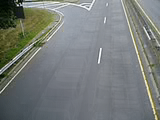

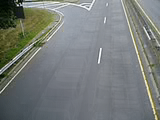

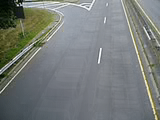

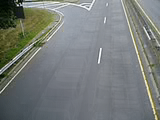

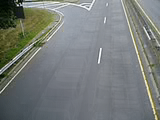

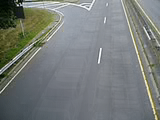

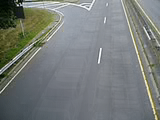

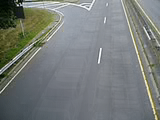

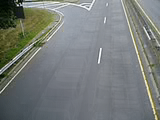

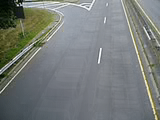

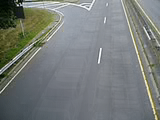

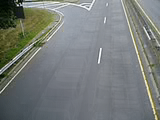

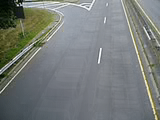

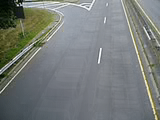

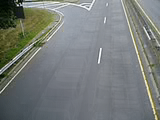

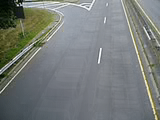

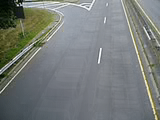

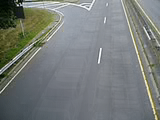

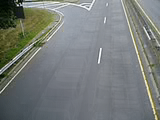

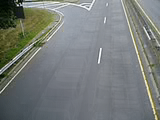

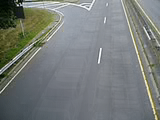

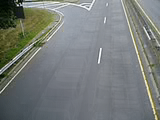

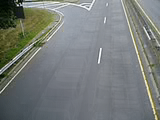

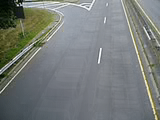

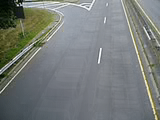

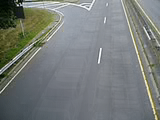

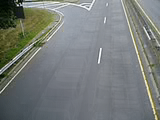

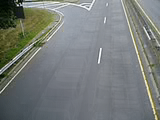

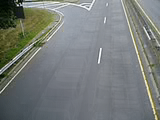

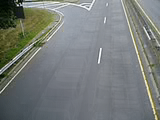

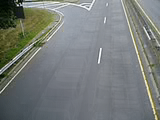

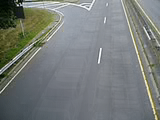

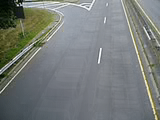

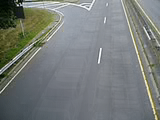

In [ ]:
# your output here
# Display and save frame averaging results
display_frames([background_image] * len(test_frames))
save_frames([background_image] * len(test_frames), output_path='./results', file_name='background_avg')


#### GMMs per pixel

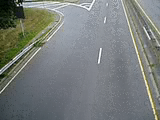

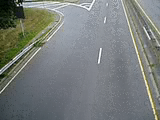

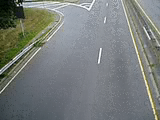

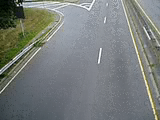

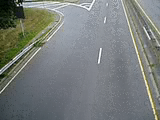

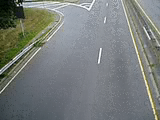

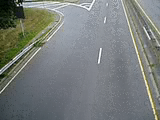

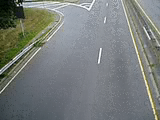

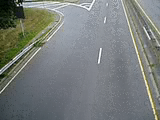

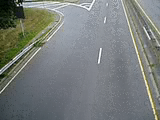

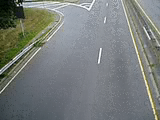

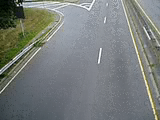

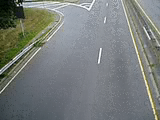

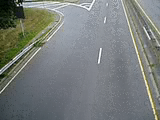

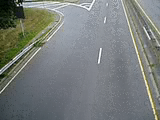

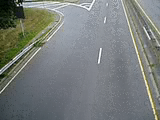

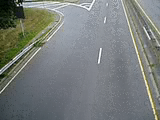

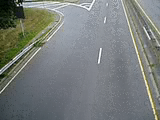

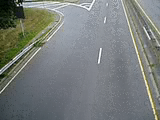

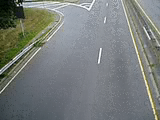

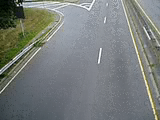

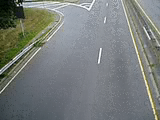

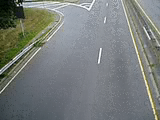

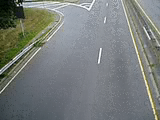

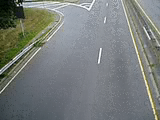

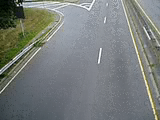

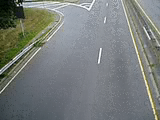

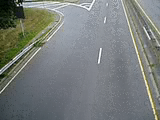

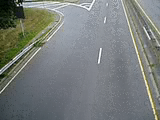

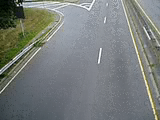

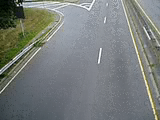

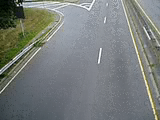

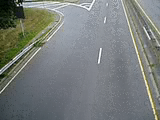

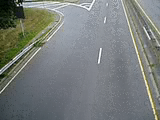

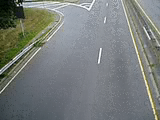

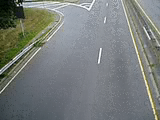

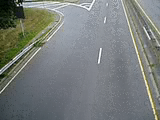

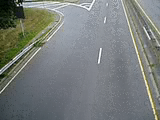

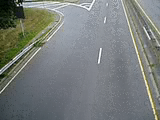

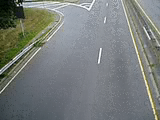

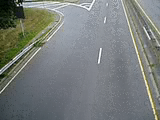

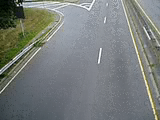

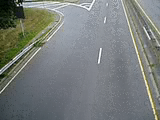

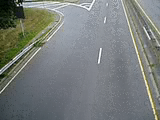

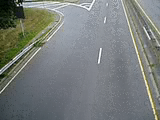

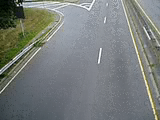

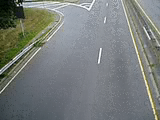

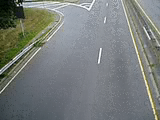

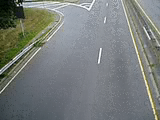

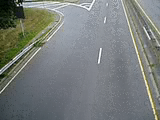

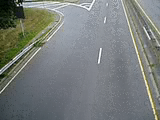

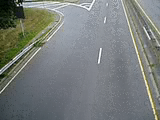

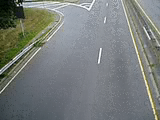

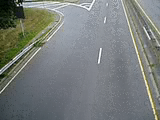

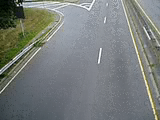

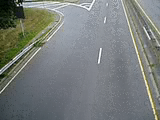

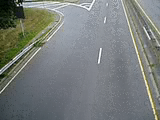

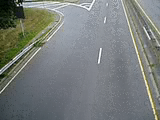

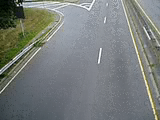

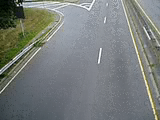

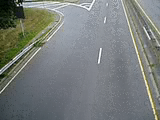

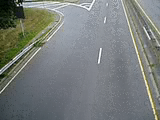

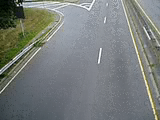

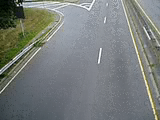

In [ ]:
# your output here
# Display and save GMMs per pixel results
display_frames([background_image_gmm_per_pixel[0]] * len(test_frames))  # Displaying the background from the first training frame
save_frames([background_image_gmm_per_pixel[0]] * len(test_frames), output_path='./results', file_name='background_gmm_per_pixel')

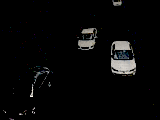

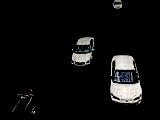

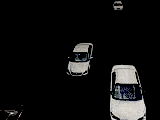

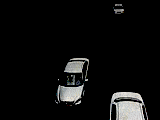

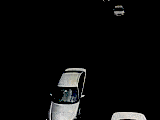

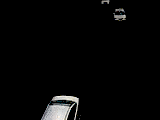

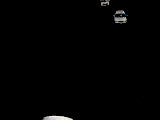

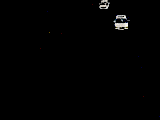

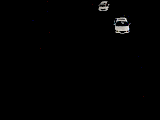

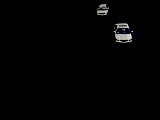

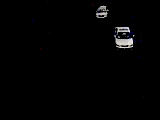

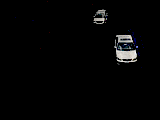

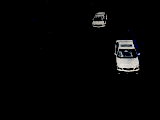

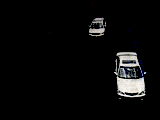

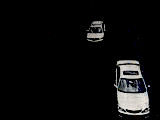

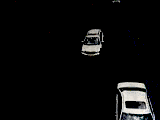

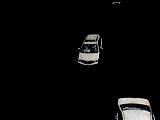

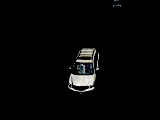

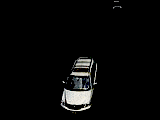

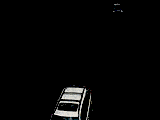

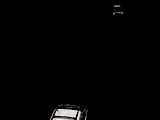

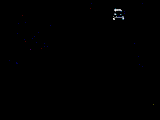

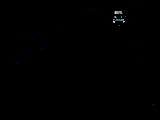

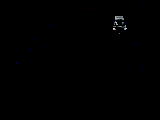

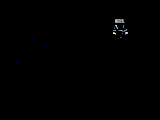

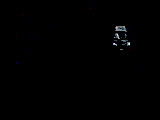

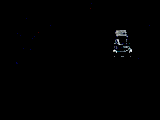

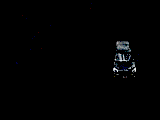

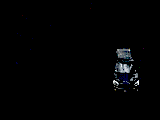

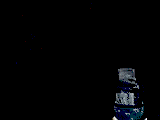

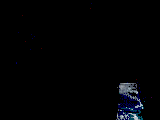

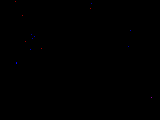

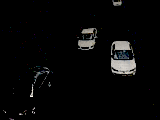

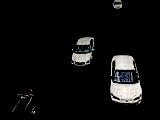

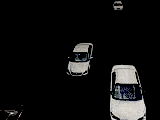

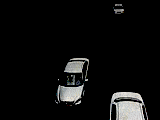

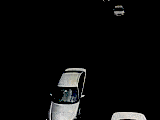

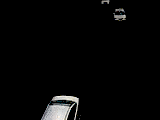

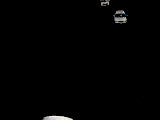

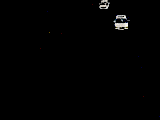

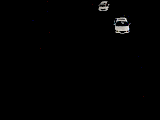

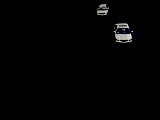

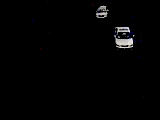

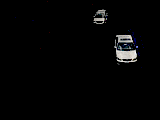

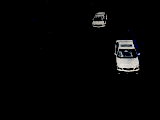

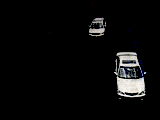

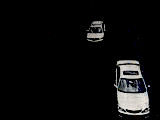

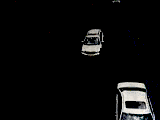

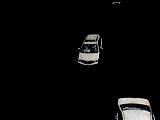

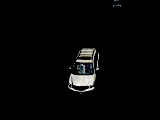

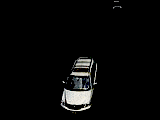

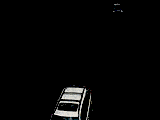

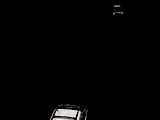

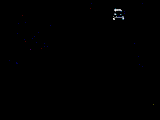

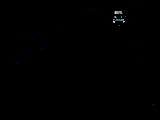

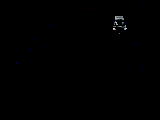

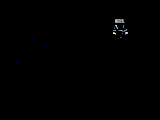

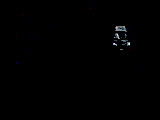

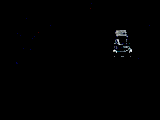

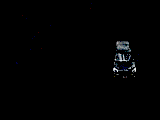

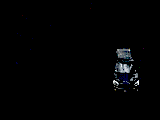

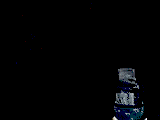

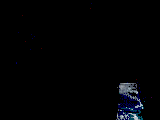

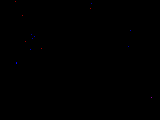

In [ ]:
# Subtract background from test frames
foreground_frames_avg = test_frames - background_image

# Thresholding - You can adjust the threshold value as needed
threshold = 0.1  # Adjust this threshold value
foreground_frames_avg[foreground_frames_avg < threshold] = 0

# Display and save frame averaging results with foreground objects
display_frames(foreground_frames_avg)
save_frames(foreground_frames_avg, output_path='./results', file_name='foreground_avg')


1843200


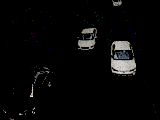

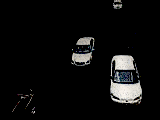

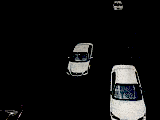

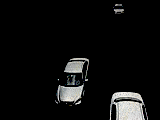

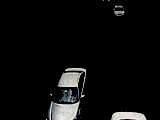

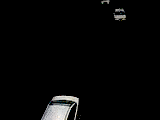

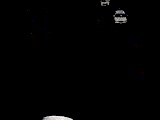

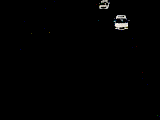

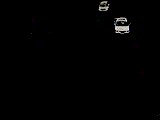

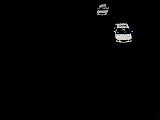

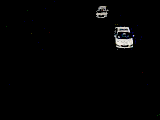

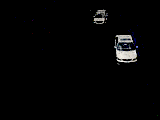

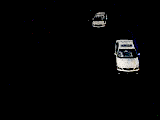

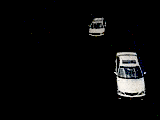

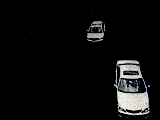

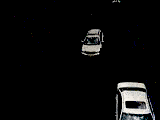

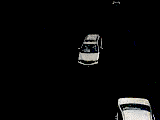

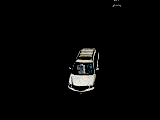

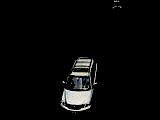

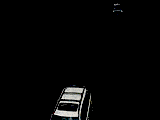

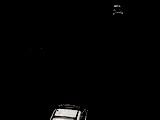

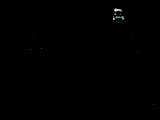

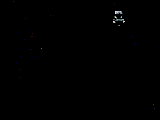

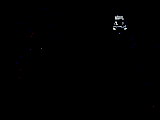

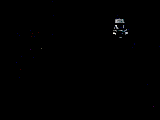

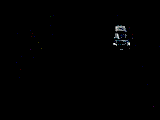

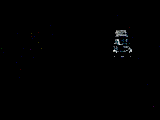

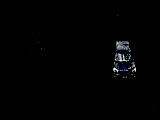

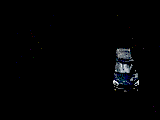

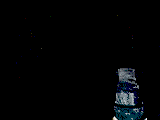

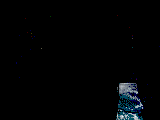

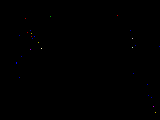

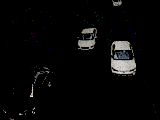

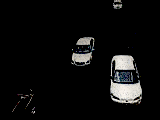

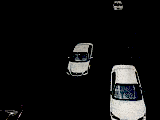

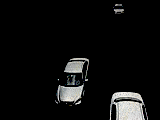

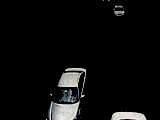

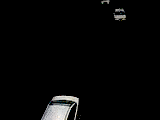

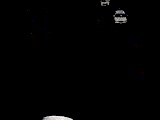

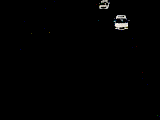

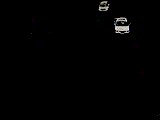

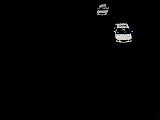

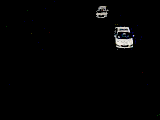

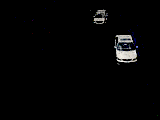

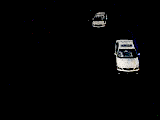

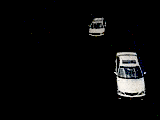

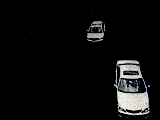

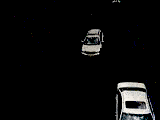

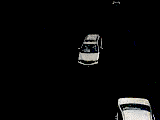

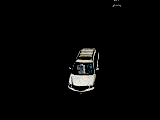

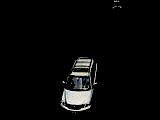

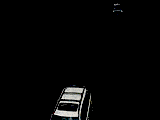

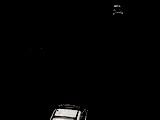

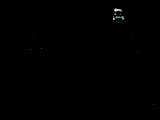

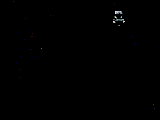

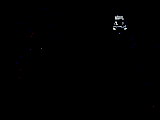

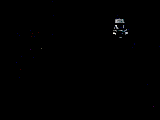

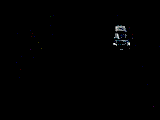

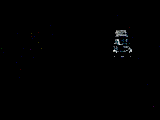

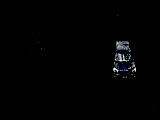

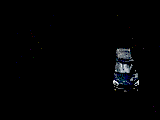

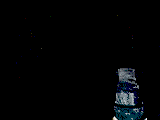

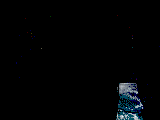

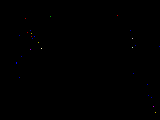

In [ ]:
# Check the size of background_image_gmm_per_pixel
print(background_image_gmm_per_pixel.size)

# Reshape background image to match the shape of test frames
# Adjust the size to match the intended shape (1, height * width, channels)

# Repeat the background image along the time axis to match the number of test frames

# Extract foreground using the trained GMM models
foreground_frames_gmm_per_pixel = test_frames - background_image_gmm_per_pixel

# Thresholding - You can adjust the threshold value as needed
threshold = 0.1  # Adjust this threshold value
foreground_frames_gmm_per_pixel[foreground_frames_gmm_per_pixel < threshold] = 0

# Reshape back to original dimensions
foreground_frames_gmm_per_pixel = foreground_frames_gmm_per_pixel.reshape((test_frames.shape[0], height, width, channels))

# Display and save GMMs per pixel results with foreground objects
display_frames(foreground_frames_gmm_per_pixel)  # Displaying the foreground from the first test frame
save_frames(foreground_frames_gmm_per_pixel, output_path='./results', file_name='foreground_gmm_per_pixel')
